In [39]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import pandas as pd
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
from tqdm.auto import tqdm


import cv2
import skimage

pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [2]:
dataDir='/Users/grantwilson/datasets/coco/'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

In [3]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.66s)
creating index...
index created!


In [4]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
outdoor sports vehicle animal food electronic indoor person furniture kitchen appliance accessory


In [5]:
# get all images containing given categories, select one at random
ids = set()
cat_ids = []
for category in ['person','dog','cat', "backpack", "potted plant"]:
    catIds = coco.getCatIds(catNms=category)
    cat_ids.append(catIds[0])
    imgIds = coco.getImgIds(catIds=catIds )
    [ids.add(i) for i in coco.getImgIds(imgIds = imgIds)]
    print(f"{category} {len(imgIds)}")


person 2693
dog 177
cat 184
backpack 228
potted plant 172


In [6]:
ids = list(ids)

In [13]:
cat_ids

[1, 18, 17, 27, 64]

In [17]:
coco.getCatIds(catNms="person")

[1]

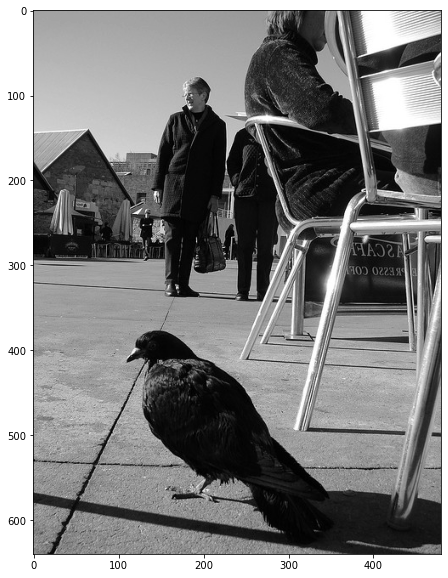

In [31]:
plt.imshow(cv2.flip(io.imread(coco.loadImgs(ids[1000])[0]["coco_url"], as_gray=True), 1), cmap="gray")

In [41]:
images = []
for i in tqdm(range(len(ids))):
    img = coco.loadImgs(ids[i])[0]
    I = io.imread(img['coco_url'], as_gray=True)
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
    anns = coco.loadAnns(annIds)

    for j in range(len(anns)):
        if not anns[j]["iscrowd"]:
            a, b, c, d = [int(k) for k in anns[j]["bbox"]]
            new_im = I[b:b+d, a:a+c]


            resized_im = cv2.resize(new_im, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
            im_cat = (anns[j]["category_id"], resized_im)
            images.append(im_cat)

            if not anns[j]["category_id"] == 1:
                flipped_im = cv2.flip(resized_im, 1)
                im_cat = (anns[j]["category_id"], flipped_im)
                images.append(im_cat)


  0%|          | 0/3046 [00:00<?, ?it/s]

In [42]:
image_category = np.array([i[0] for i in images])
image = np.array([i[1] for i in images])

In [89]:
indices = np.argwhere(image_category==1).reshape(10777)
downsize_idx = np.random.choice(indices, replace=False, size=700)
other_cat_idx = np.argwhere(image_category != 1).reshape(2266)
new_idx = np.concatenate((downsize_idx, other_cat_idx))

In [90]:
image_category = image_category[new_idx]
image = image[new_idx]

In [91]:
im_hog = []
for i in range(0, image.shape[0]):
    im_hog.append(skimage.feature.hog(image[i], visualize=True)[1])

In [92]:
np.save("hog.npy", im_hog)
np.save("image.npy", image)
np.save("image_category.npy", image_category)

In [93]:
np.savez("data", image_category, image, im_hog)

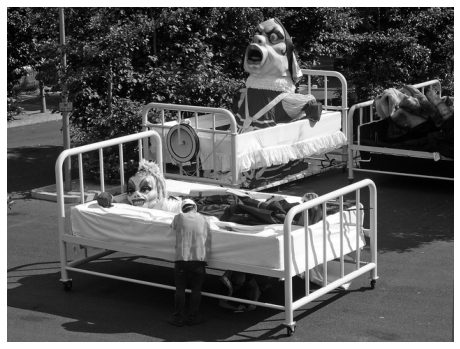

In [94]:
img = coco.loadImgs(ids[np.random.randint(0,len(ids))])[0]

# load and display image
# I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
# use url to load image
I = io.imread(img['coco_url'], as_gray=True)
plt.axis('off')
plt.imshow(I, cmap="gray")
plt.show()

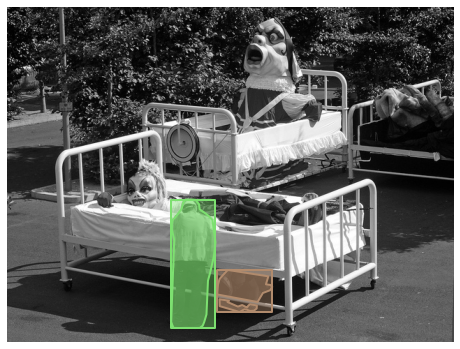

In [95]:
# load and display instance annotations
plt.imshow(I, cmap="gray"); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns, draw_bbox=True)

In [96]:
anns[0].keys()

dict_keys(['segmentation', 'area', 'iscrowd', 'image_id', 'bbox', 'category_id', 'id'])

In [98]:
a, b, c, d = [int(i) for i in anns[0]["bbox"]]

In [99]:
print((a, b, c, d))

(234, 275, 63, 184)


In [100]:
im_collection = []
for i in range(len(anns)):
    a, b, c, d = [int(j) for j in anns[i]["bbox"]]
    im_collection.append(I[b:b+d, a:a+c])

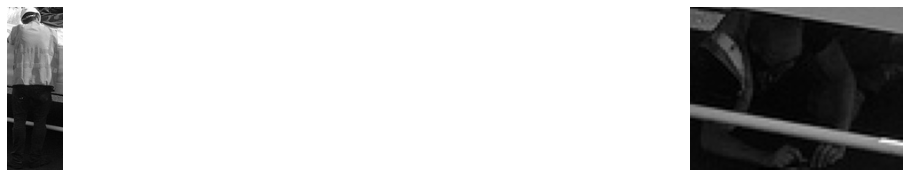

In [101]:
# create multi-row figure
plt.figure(figsize=(25, 3))


# add images to the figure from the stack
for i in range(1, len(im_collection)+1):
    plt.subplot(1, len(im_collection), i)

    # don't forget to set the cmap, vmin, vmax, and axis off
    plt.imshow(im_collection[i-1], cmap="gray")
    plt.axis("off")


plt.show()

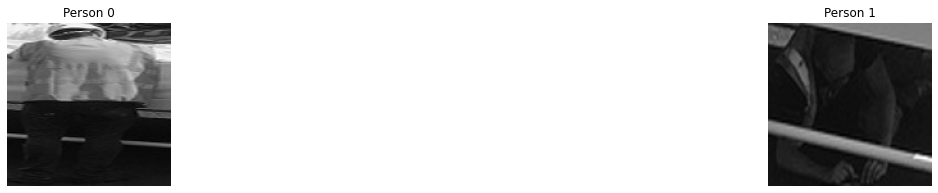

In [102]:
# create multi-row figure
plt.figure(figsize=(25, 3))

resized_images = []
# add images to the figure from the stack
for i in range(1, len(im_collection)+1):
    plt.subplot(1, len(im_collection), i)

    # don't forget to set the cmap, vmin, vmax, and axis off
    resized_im = cv2.resize(im_collection[i-1], dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
    resized_images.append(resized_im)
    plt.imshow(resized_im, cmap="gray")
    plt.axis("off")
    
    plt.title(f"Person {i-1}")


plt.show()



In [103]:
PERSON_SELECTOR = 0

In [104]:
a = np.float32(resized_images[PERSON_SELECTOR])

gx = cv2.Sobel(a, cv2.CV_32F, 1, 0, ksize=1)
gy = cv2.Sobel(a, cv2.CV_32F, 0, 1, ksize=1)

In [105]:
mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)
angle = angle%180

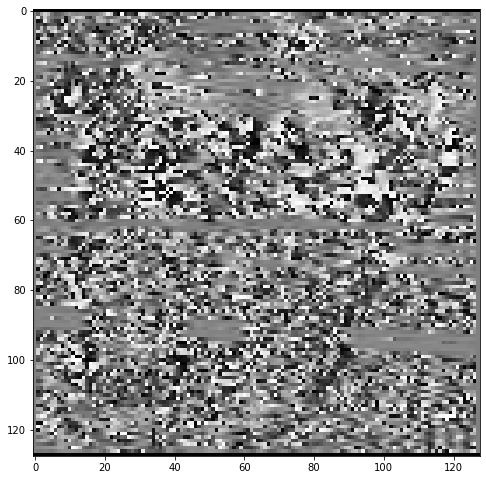

In [106]:
plt.imshow(angle, cmap="gray")

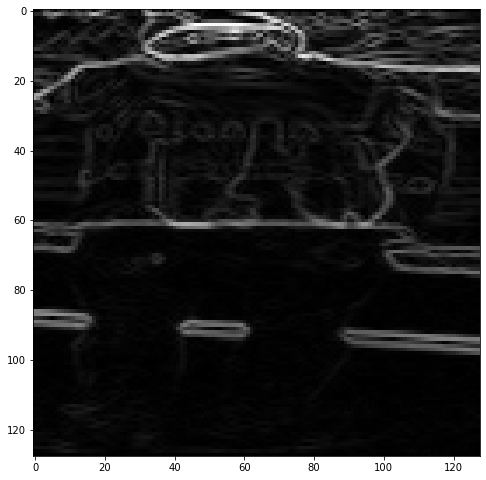

In [107]:
plt.imshow(mag, cmap="gray")

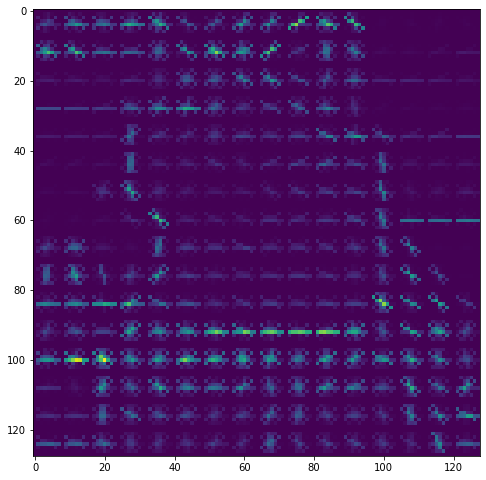

In [109]:
plt.imshow(im_hog[0])